## Advanced ML: Домашнее задание 2

Второе домашнее задание — самое большое в курсе, в нём придётся и концептуально подумать о происходящем, и технические трудности тоже порешать. Как и раньше, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Как всегда, любые комментарии, новые идеи и рассуждения на тему категорически приветствуются. <br><br>
Второе задание — это полноценный проект по анализу данных, начиная от анализа постановки задачи и заканчивая сравнением результатов разных моделей. Задача реальная и серьёзная, хотя тему я выбрал развлекательную: мы будем строить вероятностную рейтинг-систему для спортивного “Что? Где? Когда?” (ЧГК).

### Background
В спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. <br>
Соответственно, нам нужно:
* построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
* при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;
* а что сильно упрощает задачу и переводит её в область домашних заданий на EM-алгоритм — это характер данных: начиная с какого-то момента, в базу результатов начали вносить все повопросные результаты команд, т.е. в данных будут записи вида “какая команда на какой вопрос правильно ответила”.<br><br>

Я сделал за вас только первый шаг: выкачал через API <a href='https://rating.chgk.info/'>сайта рейтинга ЧГК</a> все нужные данные, чтобы сайт не прилёг под вашими многочисленными скрейперами. :) <br>
Полученные данные лежат в формате pickle вот <a href='https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip'>здесь</a>.

### Часть 1
1.	Прочитайте и проанализируйте данные, выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl). <br>

Для унификации предлагаю:
* взять в тренировочный набор турниры с dateStart из 2019 года; 
* в тестовый — турниры с dateStart из 2020 года.

In [1]:
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy import stats
from scipy.special import logit, expit

In [2]:
def get_spearman_corr(x, y):
    corr, _ = stats.spearmanr(x, y)
    return corr

def get_kendall_corr(x, y):
    corr, _ = stats.kendalltau(x, y)
    return corr

In [3]:
def get_player_name(player_id):
    player_name = str(players_data[player_id].get('name')) + ' ' + str(players_data[player_id].get('patronymic')) + ' ' + str(players_data[player_id].get('surname'))
    return player_name
                                                                                                                              

In [4]:
def get_tournament_name(tournament_id):
    tournament_name = tournaments_data[tournament_id]['name']
    return tournament_name

In [5]:
def get_scores(df, predictions_fail):
    spearman = []
    kendall = []
    
    pred_rank_df = df[['tournament_id', 'team_id']].copy()
    pred_rank_df['false_answer_prob'] = predictions_fail
    pred_rank_df = pred_rank_df.groupby(['tournament_id', 'team_id']).prod().reset_index()
    pred_rank_df['rank'] = pred_rank_df.groupby('tournament_id')['false_answer_prob'].rank(method='dense', ascending=True)
    real_rank_df = df[['tournament_id', 'team_id', 'position']].copy().drop_duplicates()
    score_df = pd.merge(pred_rank_df, real_rank_df, on=['tournament_id', 'team_id'])
    
    tournaments_list = score_df['tournament_id'].unique()
    for tournament in tournaments_list:
        tournament_data = score_df[score_df['tournament_id'] == tournament]
        spearman.append(get_spearman_corr(tournament_data['rank'], tournament_data['position']))
        kendall.append(get_kendall_corr(tournament_data['rank'], tournament_data['position']))
    return np.mean(spearman), np.mean(kendall)

In [6]:
DF_DATA_PATH = 'chgk/df_full.csv'
DF_PART_DATA_PATH = 'chgk/df_2019_2020.csv'

In [7]:
with open('chgk/players.pkl', 'rb') as f1:
    players_data = pickle.load(f1)
    
with open('chgk/results.pkl', 'rb') as f2:
    results_data = pickle.load(f2)
    
with open('chgk/tournaments.pkl', 'rb') as f3:
    tournaments_data = pickle.load(f3)

Сначала посмотрим, что из себя представляют данные

In [8]:
print(f'players_data keys: {list(players_data.keys())[:5]}')
print(f'keys len: {len(players_data.keys())}')
print(f'players data 10: {players_data[10]}')

players_data keys: [1, 10, 11, 12, 13]
keys len: 204063
players data 10: {'id': 10, 'name': 'Игорь', 'patronymic': '', 'surname': 'Абалов'}


In [9]:
print(f'players data 6212: {players_data[6212]}')

players data 6212: {'id': 6212, 'name': 'Юрий', 'patronymic': 'Яковлевич', 'surname': 'Выменец'}


In [10]:
print(f'results_data keys: {list(results_data.keys())[:10]}')
print(f'keys len: {len(results_data.keys())}')
print(f'results data 15 len: {len(results_data[15])}')
print(f'results data 15 0: {results_data[15][0]}')

results_data keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
keys len: 5528
results data 15 len: 389
results data 15 0: {'team': {'id': 188, 'name': 'Команда Губанова', 'town': {'id': 285, 'name': 'Санкт-Петербург'}}, 'mask': None, 'current': {'name': 'Привет, Петербург!', 'town': {'id': 285, 'name': 'Санкт-Петербург'}}, 'questionsTotal': 0, 'synchRequest': None, 'position': 1, 'controversials': [], 'flags': [{'id': 8, 'shortName': 'O', 'longName': 'Зачёт Этапа Кубка России'}], 'teamMembers': []}


In [11]:
print(f'tournaments_data keys: {list(tournaments_data.keys())[:25]}')
print(f'keys len: {len(tournaments_data.keys())}')
print(f'tournaments data 19 len: {len(tournaments_data[19])}')

tournaments_data keys: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27]
keys len: 5528
tournaments data 19 len: 9


In [12]:
tournaments_data[4957]

{'id': 4957,
 'name': 'Синхрон Биркиркары',
 'dateStart': '2020-02-21T00:00:00+03:00',
 'dateEnd': '2020-02-27T23:00:00+03:00',
 'type': {'id': 3, 'name': 'Синхрон'},
 'season': '/seasons/53',
 'orgcommittee': [{'id': 2421,
   'name': 'Ася',
   'patronymic': 'Сергеевна',
   'surname': 'Самойлова'},
  {'id': 54910,
   'name': 'Антон',
   'patronymic': 'Алексеевич',
   'surname': 'Пинчук'},
  {'id': 59140,
   'name': 'Борис',
   'patronymic': 'Сергеевич',
   'surname': 'Белозёров'}],
 'synchData': {'dateRequestsAllowedTo': '2020-02-27T18:00:00+03:00',
  'resultFixesTo': '2020-03-16T23:55:00+03:00',
  'resultsRecapsTo': '2020-03-01T22:55:00+03:00',
  'allowAppealCancel': True,
  'allowNarratorErrorAppeal': False,
  'dateArchivedAt': '2020-03-18T00:00:00+03:00',
  'dateDownloadQuestionsFrom': '2020-02-19T00:00:00+03:00',
  'dateDownloadQuestionsTo': '2020-02-27T22:00:00+03:00',
  'hideQuestionsTo': '2020-02-27T23:55:00+03:00',
  'hideResultsTo': '2020-02-27T23:55:00+03:00',
  'allVerdictsD

In [13]:
results_data[4957][0]

{'team': {'id': 49804,
  'name': 'Борский корабел',
  'town': {'id': 201, 'name': 'Москва'}},
 'mask': '111111011111110110X11101111000101010001',
 'current': {'name': 'Борский корабел', 'town': {'id': 201, 'name': 'Москва'}},
 'questionsTotal': 26,
 'synchRequest': {'id': 78088, 'venue': {'id': 3117, 'name': 'Москва'}},
 'position': 1,
 'controversials': [{'id': 124462,
   'questionNumber': 26,
   'answer': 'дефицит туалетной бумаги',
   'issuedAt': '2020-02-24T18:22:26+03:00',
   'status': 'A',
   'comment': None,
   'resolvedAt': '2020-03-16T13:16:29+03:00',
   'appealJuryComment': 'спорный был принят АЖ'}],
 'flags': [],
 'teamMembers': [{'flag': None,
   'usedRating': 14433,
   'rating': 14433,
   'player': {'id': 30152,
    'name': 'Артём',
    'patronymic': 'Сергеевич',
    'surname': 'Сорожкин'}},
  {'flag': None,
   'usedRating': 11978,
   'rating': 14374,
   'player': {'id': 30270,
    'name': 'Сергей',
    'patronymic': 'Леонидович',
    'surname': 'Спешков'}},
  {'flag': Non

Перенесем данные из словарей в pandas dataframe. 
* Переносить будем только те турниры, где поле 'mask' в results_data непустое.
* *В списках взятых вопросов символ "Х" означает снятый вопрос, а прочерк - вопрос, не взятый ни одной командой.* - поэтому заменим в маске 'X' и '-' на 0. <br>
* Есть еще непонятные знаки '?' - их тоже заменим на 0. <br>
* По словарю с количеством вопросов по турам посчитаем общее количество вопросов в турнире. Исключим турниры, в которых общее количество вопросов за все туры не совпадает с длиной маски ответов.<br>
* Маску ответов разобьем на отдельные строки по каждому вопросу и продублируем их для каждого игрока команды. Каждому вопросу присвоим ID: **\<ID турнира\>_\<порядковый номер вопроса в турнире\>**.<br>

In [14]:
# Нам надо вытащить турниры за 2019(train) и 2020(test) 
# 'dateStart': '2004-04-10T00:00:00+04:00'
date_format = '%Y-%m-%dT%H:%M:%S%z'
df = pd.DataFrame()

# tournaments data
tournament_id_list = []
tournament_name_list = []
type_id_list = []
type_name_list = []
date_start_list = []
date_end_list = []
year_list = []
questions_cnt = []

# teams data
team_id_list = []
team_name_list = []
position_list = []

# questions data
question_id_list = []
answer_list = []

# players data
player_id_list = []
player_name_list = []
player_rating_list = []
player_used_rating_list = []

In [15]:
%%time
for k, v in results_data.items():
    for team in v:
        for team_member in team['teamMembers']:
            date_start = datetime.strptime(tournaments_data[k]['dateStart'], date_format)
            date_end = datetime.strptime(tournaments_data[k]['dateEnd'], date_format)
            current_year = date_start.year
            mask = team.get('mask')
            if mask is not None:
                mask_str = mask.replace('X', '0').replace('-', '0').replace('?', '0')
                
                question_qty_dict = tournaments_data[k].get('questionQty')
                question_qty = sum(question_qty_dict.values())
                
                if len(mask_str) != question_qty:
                    continue
                    
                tournament_id = k
                tournament_name = tournaments_data[k].get('name')
                type_id = tournaments_data[k].get('type')['id']
                type_name = tournaments_data[k].get('type')['name']
                
                team_id = team['team']['id']
                team_name = team['team']['name']
                position = team.get('position')
                
                player_id = team_member['player']['id']
                player_name = str(players_data[player_id].get('name')) + ' ' + str(players_data[player_id].get('patronymic')) + ' ' + str(players_data[player_id].get('surname'))
                player_rating = team_member['rating']
                player_used_rating = team_member['usedRating']
                
                answers_mask = list(mask_str)
                for num, ans in enumerate(answers_mask):
                    answer_list.append(int(ans))
                    question_id_list.append(str(k) + '_' + str(num + 1))
                    
                    tournament_id_list.append(tournament_id)
                    tournament_name_list.append(tournament_name)
                    type_id_list.append(type_id)
                    type_name_list.append(type_name)
                    date_start_list.append(date_start)
                    date_end_list.append(date_end)
                    year_list.append(current_year)
                    questions_cnt.append(question_qty)

                    team_id_list.append(team_id)
                    team_name_list.append(team_name)
                    position_list.append(position)

                    player_id_list.append(player_id)
                    player_name_list.append(player_name)
                    player_rating_list.append(player_rating)
                    player_used_rating_list.append(player_used_rating)
                

CPU times: user 5min 28s, sys: 12.2 s, total: 5min 40s
Wall time: 5min 47s


In [16]:
%%time
df['tournament_id'] = tournament_id_list
df['tournament_name'] = tournament_name_list
df['type_id'] = type_id_list
df['type_name'] = type_name_list
df['date_start'] = date_start_list
df['date_end'] = date_end_list
df['year'] = year_list
df['questions_cnt'] = questions_cnt

df['team_id'] = team_id_list 
df['team_name'] = team_name_list
df['position'] = position_list

df['question_id'] = question_id_list
df['answer'] = answer_list

df['player_id'] = player_id_list
df['player_name'] = player_name_list
df['player_rating'] = player_rating_list
df['player_used_rating'] = player_used_rating_list

CPU times: user 9min 52s, sys: 2min 32s, total: 12min 25s
Wall time: 15min 15s


In [17]:
# Сохраним полученные данные
#df.to_csv(DF_DATA_PATH, index=False)

In [18]:
#df_base = pd.read_csv(DF_DATA_PATH)
#df = df_base.copy()

#df.shape

In [19]:
df.head(3)

,tournament_id,tournament_name,type_id,type_name,date_start,date_end,year,questions_cnt,team_id,team_name,position,question_id,answer,player_id,player_name,player_rating,player_used_rating
0,22,Чемпионат России,2,Обычный,2004-02-21 00:00:00+03:00,2004-02-22 00:00:00+03:00,2004,90,1,Неспроста,1.0,22_1,0,1560,Евгений Наполеонович Арутюнов,0,0
1,22,Чемпионат России,2,Обычный,2004-02-21 00:00:00+03:00,2004-02-22 00:00:00+03:00,2004,90,1,Неспроста,1.0,22_2,1,1560,Евгений Наполеонович Арутюнов,0,0
2,22,Чемпионат России,2,Обычный,2004-02-21 00:00:00+03:00,2004-02-22 00:00:00+03:00,2004,90,1,Неспроста,1.0,22_3,1,1560,Евгений Наполеонович Арутюнов,0,0


Выберем из общего массива данных турниры за 2019 и 2020 год.

In [20]:
df_2019_2020 = df.loc[(df['year'] == 2019) | (df['year'] == 2020)]

df_2019_2020.shape

(22106002, 17)

In [21]:
# Сохраним полученные данные
#df_2019_2020.to_csv(DF_PART_DATA_PATH, index=False)

In [22]:
#df_2019_2020_base = pd.read_csv(DF_PART_DATA_PATH)
#df_2019_2020 = df_2019_2020_base.copy()

#df_2019_2020.shape

In [23]:
print(f'Общее количество турниров: {df_2019_2020["tournament_id"].nunique()}')
print(f'Общее количество команд: {df_2019_2020["team_id"].nunique()}')
print(f'Общее количество игроков: {df_2019_2020["player_id"].nunique()}')
print(f'Общее количество вопросов: {df_2019_2020["question_id"].nunique()}')

Общее количество турниров: 847
Общее количество команд: 13136
Общее количество игроков: 63479
Общее количество вопросов: 41184


Выберем в train_data турниры 2019 года, в test_data - турниры 2020 года.

In [24]:
train_data = df_2019_2020.loc[df_2019_2020['year'] == 2019]
test_data = df_2019_2020.loc[df_2019_2020['year'] == 2020]
train_data.shape, test_data.shape

((17838582, 17), (4267420, 17))

Синхрон              11831244
Обычный               2712609
Асинхрон              1721745
Общий зачёт           1514736
Строго синхронный       58248
Name: type_name, dtype: int64

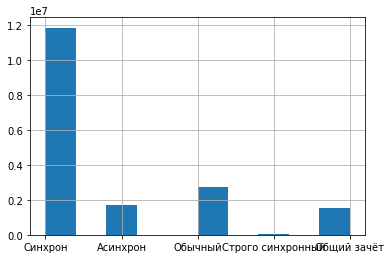

In [25]:
train_data['type_name'].hist()
train_data['type_name'].value_counts()

<AxesSubplot:>

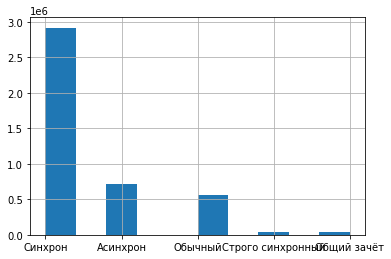

In [26]:
test_data['type_name'].hist()

Удалим из выборок турниры только с одной командой. И турниры типа "Общий зачет", так как, кажется, этот тип как-то аггрегирует остальные типы турниров, хотя я могу ошибаться.

In [27]:
train_data[['tournament_id','team_id']].groupby(by='tournament_id').agg(
    team_cnt = pd.NamedAgg(column='team_id', aggfunc='nunique')
).sort_values(by='team_cnt', ascending=True).head()

,team_cnt
tournament_id,
6102,1
5876,1
6051,3
5749,3
5554,3


In [28]:
teams_6102_5876 = train_data.loc[train_data['tournament_id'].isin([6102, 5876]), 'team_id'].unique()
bad_tournament_ind = train_data.loc[train_data['tournament_id'].isin([6102, 5876])].index
train_data = train_data.drop(bad_tournament_ind, axis=0)

bad_type_tournament_ind = train_data.loc[train_data['type_name'] == 'Общий зачёт'].index
train_data = train_data.drop(bad_type_tournament_ind, axis=0)

train_data.shape

(16323594, 17)

In [29]:
test_data[['tournament_id','team_id']].groupby(by='tournament_id').agg(
    team_cnt = pd.NamedAgg(column='team_id', aggfunc='nunique')
).sort_values(by='team_cnt', ascending=True).head()

,team_cnt
tournament_id,
6362,1
6409,3
6188,3
6410,5
6256,6


In [30]:
teams_6362 = test_data.loc[test_data['tournament_id'] == 6362, 'team_id'].unique()
bad_tournament_ind = test_data.loc[test_data['tournament_id'] == 6362].index
test_data = test_data.drop(bad_tournament_ind, axis=0)

bad_type_tournament_ind = test_data.loc[test_data['type_name'] == 'Общий зачёт'].index
test_data = test_data.drop(bad_type_tournament_ind, axis=0)

test_data.shape

(4230394, 17)

In [31]:
print(f'Количество турниров TRAIN: {train_data["tournament_id"].nunique()}')
print(f'Количество команд TRAIN: {train_data["team_id"].nunique()}')
print(f'Количество игроков TRAIN: {train_data["player_id"].nunique()}')
print(f'Количество вопросов TRAIN: {train_data["question_id"].nunique()}')
print()
print(f'Количество турниров TEST: {test_data["tournament_id"].nunique()}')
print(f'Количество команд TEST: {test_data["team_id"].nunique()}')
print(f'Количество игроков TEST: {test_data["player_id"].nunique()}')
print(f'Количество вопросов TEST: {test_data["question_id"].nunique()}')

Количество турниров TRAIN: 664
Количество команд TRAIN: 11420
Количество игроков TRAIN: 57228
Количество вопросов TRAIN: 31509

Количество турниров TEST: 168
Количество команд TEST: 5857
Количество игроков TEST: 28996
Количество вопросов TEST: 7443


In [32]:
train_data.head(3)

,tournament_id,tournament_name,type_id,type_name,date_start,date_end,year,questions_cnt,team_id,team_name,position,question_id,answer,player_id,player_name,player_rating,player_used_rating
65993600,4772,Синхрон северных стран. Зимний выпуск,3,Синхрон,2019-01-05 19:00:00+03:00,2019-01-09 19:00:00+03:00,2019,36,45556,Рабочее название,1.0,4772_1,1,6212,Юрий Яковлевич Выменец,13507,13507
65993601,4772,Синхрон северных стран. Зимний выпуск,3,Синхрон,2019-01-05 19:00:00+03:00,2019-01-09 19:00:00+03:00,2019,36,45556,Рабочее название,1.0,4772_2,1,6212,Юрий Яковлевич Выменец,13507,13507
65993602,4772,Синхрон северных стран. Зимний выпуск,3,Синхрон,2019-01-05 19:00:00+03:00,2019-01-09 19:00:00+03:00,2019,36,45556,Рабочее название,1.0,4772_3,1,6212,Юрий Яковлевич Выменец,13507,13507


In [33]:
test_data.head(3)

,tournament_id,tournament_name,type_id,type_name,date_start,date_end,year,questions_cnt,team_id,team_name,position,question_id,answer,player_id,player_name,player_rating,player_used_rating
69130374,4957,Синхрон Биркиркары,3,Синхрон,2020-02-21 00:00:00+03:00,2020-02-27 23:00:00+03:00,2020,39,49804,Борский корабел,1.0,4957_1,1,30152,Артём Сергеевич Сорожкин,14433,14433
69130375,4957,Синхрон Биркиркары,3,Синхрон,2020-02-21 00:00:00+03:00,2020-02-27 23:00:00+03:00,2020,39,49804,Борский корабел,1.0,4957_2,1,30152,Артём Сергеевич Сорожкин,14433,14433
69130376,4957,Синхрон Биркиркары,3,Синхрон,2020-02-21 00:00:00+03:00,2020-02-27 23:00:00+03:00,2020,39,49804,Борский корабел,1.0,4957_3,1,30152,Артём Сергеевич Сорожкин,14433,14433


### Часть 2
2.	Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.<br> 

Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Для baseline модели преобразуем наши тренировочные данные, а именно 'player_id' и 'question_id' в one-hot-вектора.<br> И обучим на них логистическую регрессию.<br>  В качестве вектора ответов для классификации будут служить ответы игрока на вопрос - признак 'answer'.<br> В результате получим веса для каждого игрока и каждого вопроса из обучающей выборки, на основании которых можем ранжировать.

In [34]:
encoder = OneHotEncoder(dtype=int, handle_unknown='ignore')

train_ohe = encoder.fit_transform(train_data[['player_id', 'question_id']])
answer_train = train_data['answer']

test_ohe = encoder.transform(test_data[['player_id', 'question_id']])
answer_test = test_data['answer']

train_ohe.shape, test_ohe.shape

((16323594, 88737), (4230394, 88737))

In [35]:
%%time
baseline_model = LogisticRegression(n_jobs=-1, random_state=8, fit_intercept=False)
baseline_model.fit(train_ohe, answer_train)

CPU times: user 1.03 s, sys: 1.08 s, total: 2.11 s
Wall time: 1min 49s


LogisticRegression(fit_intercept=False, n_jobs=-1, random_state=8)

In [36]:
players_cnt = train_data['player_id'].nunique()
ohe_feature_names = encoder.get_feature_names_out()

baseline_results = pd.DataFrame()

players = ohe_feature_names[:players_cnt]
players = list(map(lambda x: int(x.split('_')[-1]), players))
player_names = list(map(get_player_name, players))
ratings = baseline_model.coef_[0][:players_cnt]
baseline_results['player_id'] = players
baseline_results['player_name'] = player_names
baseline_results['baseline_rating'] = ratings
baseline_results = baseline_results.sort_values(by='baseline_rating', ascending=False)
baseline_results['baseline_position'] = baseline_results['baseline_rating'].rank(method='dense', ascending=False)

In [37]:
baseline_results.head(20)

,player_id,player_name,baseline_rating,baseline_position
3858,27403,Максим Михайлович Руссо,3.502049,1.0
604,4270,Александра Владимировна Брутер,3.375911,2.0
4047,28751,Иван Николаевич Семушин,3.330963,3.0
3930,27822,Михаил Владимирович Савченков,3.242704,4.0
4235,30152,Артём Сергеевич Сорожкин,3.162126,5.0
4255,30270,Сергей Леонидович Спешков,3.158448,6.0
2925,20691,Станислав Григорьевич Мереминский,3.040634,7.0
2567,18036,Михаил Ильич Левандовский,2.986852,8.0
3677,26089,Ирина Сергеевна Прокофьева,2.942844,9.0
3224,22799,Сергей Игоревич Николенко,2.920350,10.0


Оценивать будем на данных за 2019 год. Для оценки вытащим последний актуальный рейтинг игрока из данных о результатах турниров - атрибут 'rating'.

In [38]:
real_results = train_data[['player_id', 'player_rating', 'date_start']].groupby(by='player_id').agg(
    last_date = pd.NamedAgg(column='date_start', aggfunc=max),
    rating_2019 = pd.NamedAgg(column='player_rating', aggfunc=max)
)
real_results = real_results.sort_values(by='rating_2019', ascending=False)
real_results['real_2019_position'] = real_results['rating_2019'].rank(method='dense', ascending=False)
real_results.head(10)

,last_date,rating_2019,real_2019_position
player_id,,,
30152,2019-12-29 19:00:00+03:00,14897,1.0
28751,2019-12-25 19:30:00+03:00,14789,2.0
27822,2019-12-26 14:00:00+03:00,14726,3.0
30270,2019-12-29 19:00:00+03:00,14708,4.0
4270,2019-12-15 13:00:00+03:00,14543,5.0
27403,2019-12-15 13:00:00+03:00,14543,5.0
18332,2019-12-26 00:00:00+03:00,14181,6.0
16837,2019-12-26 00:00:00+03:00,14151,7.0
6212,2019-12-25 19:30:00+03:00,14083,8.0


In [39]:
baseline_model_result = pd.merge(baseline_results, real_results, on='player_id').drop(['last_date'], axis=1)
baseline_model_result.head(20)

,player_id,player_name,baseline_rating,baseline_position,rating_2019,real_2019_position
0,27403,Максим Михайлович Руссо,3.502049,1.0,14543,5.0
1,4270,Александра Владимировна Брутер,3.375911,2.0,14543,5.0
2,28751,Иван Николаевич Семушин,3.330963,3.0,14789,2.0
3,27822,Михаил Владимирович Савченков,3.242704,4.0,14726,3.0
4,30152,Артём Сергеевич Сорожкин,3.162126,5.0,14897,1.0
5,30270,Сергей Леонидович Спешков,3.158448,6.0,14708,4.0
6,20691,Станислав Григорьевич Мереминский,3.040634,7.0,13914,14.0
7,18036,Михаил Ильич Левандовский,2.986852,8.0,13709,28.0
8,26089,Ирина Сергеевна Прокофьева,2.942844,9.0,13302,64.0
9,22799,Сергей Игоревич Николенко,2.920350,10.0,14057,10.0


Топ-5 можно почти совпадают.

In [40]:
baseline_model_result.tail()

,player_id,player_name,baseline_rating,baseline_position,rating_2019,real_2019_position
57223,209400,Илья Владиславович Шапуров,-4.121348,34829.0,0,9194.0
57224,209401,Михаил Максимович Казарин,-4.121348,34829.0,0,9194.0
57225,203842,Вероника Андреевна Балакина,-4.143998,34830.0,0,9194.0
57226,203845,Андрей Кириллович Бурштын,-4.256500,34831.0,0,9194.0
57227,203843,Анастасия Павловна Чурсина,-4.525998,34832.0,0,9194.0


In [41]:
spearman = get_spearman_corr(baseline_model_result['baseline_position'], baseline_model_result['real_2019_position'])
kendall = get_kendall_corr(baseline_model_result['baseline_position'], baseline_model_result['real_2019_position'])
print(f'Корреляция Спирмена на множестве 2019 года : {spearman}')
print(f'Корреляция Кендалла на множестве 2019 года : {kendall}')        

Корреляция Спирмена на множестве 2019 года : 0.7080075001165946
Корреляция Кендалла на множестве 2019 года : 0.5609253468632742


### Часть 3
3.	Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. <br>

Поэтому:
* предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
* в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров.

**Для самопроверки**: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг.

Сделаем предсказание baseline-модели на тестовой выборке. Так как при кодировании мы использовали параметр handle_unknown='ignore', то все признаки вопросов будут нулями, также в ohe-представление тестовой выборки не попадут новые игроки(точнее для них будут нулевые строки). То есть в этом варианте мы действительно будем предсказывать результаты только для известных составов. А для всех новых игроков получится какая-то одинаковая вероятность, скорее всего невысокая. Предсказания модели будем интерпретировать как вероятности $p_i$ для конкретных игроков правильно ответить на новый вопрос. Тогда силу j-ой команды будем предсказывать как $P_j=1-\prod_i{(1-p_i)}$ - вероятность хотя бы одного игрока правильно ответить на вопрос.

In [42]:
predictions_fail = baseline_model.predict_proba(test_ohe)[:, 0]

In [43]:
spearman, kendall = get_scores(test_data, predictions_fail)

print(f'(Baseline) Корреляция Спирмена, усреднённая по тестовому множеству турниров: {spearman}')
print(f'(Baseline) Корреляция Кендалла, усреднённая по тестовому множеству турниров: {kendall}') 

(Baseline) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7235551660702599
(Baseline) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.5702412155905212


### Часть 4
4.	Теперь главное: ЧГК — это всё-таки командная игра. <br>

Поэтому:
* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

Вектор скрытых переменных - вероятность ответа игроком на вопрос при условии команды: $z=P(player=1|team)$<br>
При этом $P(player=1|team=0)=0$<br>
На e-шаге оцениваем вероятности ответа на вопрос игрока при условии команды: $P(player=1|team=1)=\frac{P(team=1|player=1)P(player=1)}{P(team=1)}=\frac{P(player=1)}{P(team=1)}$<br>
На m-шаге обучаем линейную регрессию на оцененных вероятностях.<br>
"Силу" команды будем считать также, как на предыдущем шаге - как вероятность хотя бы одного игрока правильно ответить на вопрос.

In [44]:
%%time
train_em = train_data.copy()
train_em['player_probability'] = baseline_model.predict_proba(train_ohe)[:, 1]

em_model = LinearRegression(n_jobs=-1)

def e_step(df):
    df.loc[df['answer'] == 0, 'player_probability'] = 0
    ind = df['answer'] == 1
    team_probability = df.loc[ind].groupby(['tournament_id', 'team_id', 'question_id'])['player_probability'].transform(lambda p: 1 - np.prod(1 - p.values))
    df['z'] = df['player_probability']
    df.loc[ind, 'z'] = df.loc[ind, 'z'] / team_probability
    df['z'] = np.clip(df['z'], 1e-6, 1 - 1e-6)
    return df

def m_step(df):
    em_model.fit(train_ohe, logit(df['z']))
    df['player_probability'] = expit(em_model.predict(train_ohe))
    return df


for iteration in range(5):
    train_em = e_step(train_em)
    train_em = m_step(train_em)
   
    predictions = expit(em_model.predict(test_ohe))
    predictions_false = 1 - predictions
    
    spearman, kendall = get_scores(test_data, predictions_false)
    print(f'(EM iteration {iteration}) Корреляция Спирмена, усреднённая по тестовому множеству турниров: {spearman}')
    print(f'(EM iteration {iteration}) Корреляция Кендалла, усреднённая по тестовому множеству турниров: {kendall}') 
    print()
    

(EM iteration 0) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7698643738442654
(EM iteration 0) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6136746213669078

(EM iteration 1) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7774264662655485
(EM iteration 1) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6227650180747226

(EM iteration 2) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7804405193796098
(EM iteration 2) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6267991153159351

(EM iteration 3) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7818547278813716
(EM iteration 3) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6282135105021878

(EM iteration 4) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7817499473532317
(EM iteration 4) Корреляция Кендалла, усреднённая по тестовому множеству турни

Метрики медленно растут.

In [45]:
em_model_results = pd.DataFrame()

players = ohe_feature_names[:players_cnt]
players = list(map(lambda x: int(x.split('_')[-1]), players))
ratings = em_model.coef_[:players_cnt]
em_model_results['player_id'] = players
em_model_results['player_name'] = player_names
em_model_results['em_rating'] = ratings
em_model_results = em_model_results.sort_values(by='em_rating', ascending=False)
em_model_results['em_position'] = em_model_results['em_rating'].rank(method='dense', ascending=False)

In [46]:
em_model_results.head(10)

,player_id,player_name,em_rating,em_position
5353,38175,Максим Игоревич Пилипенко,15.348707,1.0
3180,22474,Илья Сергеевич Немец,14.236252,2.0
15620,135951,Артём Феликсович Стетой,14.117455,3.0
39830,199963,Елена Борисовна Бровченко,13.960164,4.0
2114,14996,Ольга Александровна Козлова,12.559562,5.0
15196,133504,София Евгеньевна Лебедева,12.250887,6.0
42025,202410,Валентина Подюкова,12.025688,7.0
13358,121433,София Романовна Савенко,11.795687,8.0
51602,212663,Майя Александровна Губина,11.618830,9.0
13665,123750,Сергей Андреевич Завьялов,11.363882,10.0


Посмотрим на все результаты сразу

In [47]:
result = pd.merge(baseline_model_result, em_model_results, on=['player_id', 'player_name'])

In [48]:
result.head(20)

,player_id,player_name,baseline_rating,baseline_position,rating_2019,real_2019_position,em_rating,em_position
0,27403,Максим Михайлович Руссо,3.502049,1.0,14543,5.0,9.975997,26.0
1,4270,Александра Владимировна Брутер,3.375911,2.0,14543,5.0,9.412617,40.0
2,28751,Иван Николаевич Семушин,3.330963,3.0,14789,2.0,9.410857,41.0
3,27822,Михаил Владимирович Савченков,3.242704,4.0,14726,3.0,9.258716,50.0
4,30152,Артём Сергеевич Сорожкин,3.162126,5.0,14897,1.0,9.389788,45.0
5,30270,Сергей Леонидович Спешков,3.158448,6.0,14708,4.0,8.858682,67.0
6,20691,Станислав Григорьевич Мереминский,3.040634,7.0,13914,14.0,9.346116,46.0
7,18036,Михаил Ильич Левандовский,2.986852,8.0,13709,28.0,8.716965,74.0
8,26089,Ирина Сергеевна Прокофьева,2.942844,9.0,13302,64.0,8.236090,108.0
9,22799,Сергей Игоревич Николенко,2.920350,10.0,14057,10.0,7.635401,202.0


Как-то очень сильно отличаются результаты у baseline модели и em алгоритма.

### Часть 5
5.	А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? <br>

Если будет интересно: постройте топ сложных и простых вопросов со ссылками на конкретные записи в <a href='https://db.chgk.info/'>базе вопросов ЧГК</a> (это чисто техническое дело, тут никакого ML нету).

Отранжируем вопросы также как ранжировали игроков - по коэффициентам модели. Только для игроков: чем больше вес - тем сильнее игрок, а для вопросов получится наоборот - если у него большой вес, значит больше игроков отвечают на него правильно (таким вопросам чаще соответсвуют 1 в векторе ответов), значит такой вопрос легче, а на те, у которых меньше вес, соответственно, отвечают реже, и с ними соотносится больше нулей в векторе ответов.

In [49]:
players_cnt = train_data['player_id'].nunique()
ohe_feature_names = encoder.get_feature_names_out()

em_questions_results = pd.DataFrame()
questions = ohe_feature_names[players_cnt:]
questions = list(map(lambda x: '_'.join(x.split('_')[-2:]), questions))
tournaments = list(map(lambda x: int(x.split('_')[-2]), questions))
tournament_names = list(map(get_tournament_name, tournaments))
ratings = em_model.coef_[players_cnt:]
em_questions_results['tournament_id'] = tournaments
em_questions_results['tournament_name'] = tournament_names
em_questions_results['rating'] = ratings

em_questions_results  = em_questions_results.groupby(['tournament_id', 'tournament_name'])['rating'].mean().reset_index()
em_questions_results = em_questions_results.sort_values(by='rating', ascending=True)
em_questions_results['em_position'] = em_questions_results['rating'].rank(method='dense', ascending=True)

In [50]:
em_questions_results.head(10)

,tournament_id,tournament_name,rating,em_position
655,6149,Чемпионат Санкт-Петербурга. Первая лига,-6.799646,1.0
535,5928,Угрюмый Ёрш,-4.906655,2.0
366,5684,Синхрон высшей лиги Москвы,-4.325665,3.0
632,6101,Воображаемый музей,-4.136186,4.0
43,5159,Первенство правого полушария,-4.089828,5.0
546,5942,Чемпионат Мира. Этап 2. Группа В,-3.919977,6.0
178,5465,Чемпионат России,-3.874068,7.0
374,5693,Знание – Сила VI,-3.837762,8.0
545,5941,Чемпионат Мира. Этап 2. Группа А,-3.788580,9.0
26,5083,Ускользающая сова,-3.740696,10.0


In [51]:
em_questions_results.tail(10)

,tournament_id,tournament_name,rating,em_position
7,5009,(а)Синхрон-lite. Лига старта. Эпизод III,5.128039,655.0
557,5954,Школьная лига. II тур.,5.178149,656.0
381,5702,(а)Синхрон-lite. Лига старта. Эпизод IX,5.180602,657.0
377,5698,(а)Синхрон-lite. Лига старта. Эпизод VII,5.203259,658.0
10,5012,Школьный Синхрон-lite. Выпуск 2.5,5.305989,659.0
172,5457,Студенческий чемпионат Калининградской области,5.455705,660.0
540,5936,Школьная лига. I тур.,5.474375,661.0
558,5955,Школьная лига. III тур.,5.485559,662.0
11,5013,(а)Синхрон-lite. Лига старта. Эпизод V,5.733210,663.0
154,5438,Синхрон Лиги Разума,5.910118,664.0


В топ попали чемпионаты мира и первая лига, а в конец рейтинга школьные турниры - все выглядит как ожидали.

### Часть 6
6.	**Бонус**: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли. Скорее всего, вы увидите, что топ занят игроками, которые сыграли совсем мало вопросов, около 100 или даже меньше; если вы поищете их в <a href='https://rating.chgk.info/'>официальном рейтинге ЧГК</a>, вы увидите, что это какие-то непонятные ноунеймы. В baseline-модели, скорее всего, такой эффект будет гораздо слабее.<br>

Это естественное свойство модели: за счёт EM-схемы влияние 1-2 удачно сыгранных турниров будет только усиливаться, потому что неудачных турниров, чтобы его компенсировать, у этих игроков нет. Более того, это не мешает метрикам качества, потому что если эти игроки сыграли всего 1-2 турнира в 2019-м, скорее всего они ничего или очень мало сыграли и в 2020, и их рейтинги никак не влияют на качество тестовых предсказаний. Но для реального рейтинга такое свойство, конечно, было бы крайне нежелательным. <br>

Давайте попробуем его исправить:
* сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;
* можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;
* но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
* предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).

**Для самопроверки**: а вот те игроки, кто сыграл от тысячи вопросов и больше и при этом всё равно попал в топ-100 весов модели, должны быть настоящими топовыми игроками из ведущих команд официального рейтинга. Если это не так, опять же, скорее всего где-то баг.

In [52]:
question_count_data = train_data[['player_id', 'player_name', 'answer']].copy()
question_count_data = question_count_data.groupby(['player_id', 'player_name']).agg(
    questions_total=pd.NamedAgg(column='answer', aggfunc='count'),
    questions_true=pd.NamedAgg(column='answer', aggfunc='sum')
).reset_index()
em_players_data = pd.merge(question_count_data, em_model_results, on=['player_id', 'player_name']).sort_values(by='em_position')
baseline_players_data = pd.merge(question_count_data, baseline_results, on=['player_id', 'player_name']).sort_values(by='baseline_position')


In [53]:
em_players_data.head(10)

,player_id,player_name,questions_total,questions_true,em_rating,em_position
5353,38175,Максим Игоревич Пилипенко,36,29,15.348707,1.0
3180,22474,Илья Сергеевич Немец,75,45,14.236252,2.0
15620,135951,Артём Феликсович Стетой,36,32,14.117455,3.0
39830,199963,Елена Борисовна Бровченко,36,32,13.960164,4.0
2114,14996,Ольга Александровна Козлова,36,27,12.559562,5.0
15196,133504,София Евгеньевна Лебедева,36,32,12.250887,6.0
42025,202410,Валентина Подюкова,36,33,12.025688,7.0
13358,121433,София Романовна Савенко,36,33,11.795687,8.0
51602,212663,Майя Александровна Губина,72,50,11.618830,9.0
13665,123750,Сергей Андреевич Завьялов,36,28,11.363882,10.0


In [54]:
baseline_players_data.head(10)

,player_id,player_name,questions_total,questions_true,baseline_rating,baseline_position
3858,27403,Максим Михайлович Руссо,2195,1747,3.502049,1.0
604,4270,Александра Владимировна Брутер,2711,2150,3.375911,2.0
4047,28751,Иван Николаевич Семушин,3803,2983,3.330963,3.0
3930,27822,Михаил Владимирович Савченков,3236,2513,3.242704,4.0
4235,30152,Артём Сергеевич Сорожкин,4885,3711,3.162126,5.0
4255,30270,Сергей Леонидович Спешков,3767,2860,3.158448,6.0
2925,20691,Станислав Григорьевич Мереминский,1595,1165,3.040634,7.0
2567,18036,Михаил Ильич Левандовский,1470,1063,2.986852,8.0
3677,26089,Ирина Сергеевна Прокофьева,1081,780,2.942844,9.0
3224,22799,Сергей Игоревич Николенко,2235,1479,2.920350,10.0


Да, действительно, для em-модели в топе игроки, которые сыграли совсем мало вопросов.

Самопроверка по топ-100 em-модели - вроде похоже на правду.
В baseline-модели такие игроки были еще в топ-10.

In [55]:
em_top_100 = em_players_data.head(100).copy()
em_top_100.loc[em_top_100['questions_total']>1000]

,player_id,player_name,questions_total,questions_true,em_rating,em_position
3858,27403,Максим Михайлович Руссо,2195,1747,9.975997,26.0
2230,15727,Александр Геннадьевич Коробейников,1412,982,9.423211,39.0
604,4270,Александра Владимировна Брутер,2711,2150,9.412617,40.0
4047,28751,Иван Николаевич Семушин,3803,2983,9.410857,41.0
988,7008,Алексей Владимирович Гилёв,4341,3163,9.402579,43.0
4235,30152,Артём Сергеевич Сорожкин,4885,3711,9.389788,45.0
2925,20691,Станислав Григорьевич Мереминский,1595,1165,9.346116,46.0
3930,27822,Михаил Владимирович Савченков,3236,2513,9.258716,50.0
2608,18332,Александр Витальевич Либер,3821,2747,8.987114,62.0
8159,74001,Игорь Викторович Мокин,1188,806,8.924889,64.0


Пробуем исправить: <br>
1. сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50<br>
Возьмем среднее значение, округленное до 100: 300. Это соответствует примерно 7-8 сыгранным турнирам.

In [56]:
threshold = round(question_count_data['questions_total'].mean() / 100) * 100
threshold, threshold / 40

(300, 7.5)

2. можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель

In [57]:
print(f'Все игроки: {question_count_data.shape[0]}')
print(f'Игроки, сыгравшие менее {threshold} игр: {question_count_data.loc[question_count_data["questions_total"]<threshold].shape[0]}')

Все игроки: 57228
Игроки, сыгравшие менее 300 игр: 44985


Игроков, сыгравших менее 300 игр очень много, если их всех выбросить - мы потеряем большую часть обучающей выборки. Кроме того, команды могут состоять как из рейтинговых игроков, так и из неопытных. По идее мы не можем выкинуть из команды игрока - тогда оценка "силы" команды будет неправдоподобной. Получается надо выкидывать целиком команды, в составе которых есть нерейтинговые игроки или вообще турниры - это неправильно. Лучше, если мы заменим "силу" игроков, сыгравших небольшое количество вопросов на какое-то дефолтное значение, например 0.5. А, начиная с количества вопросов в 300, будем ставить силу, которую посчитала модель.

In [58]:
rating_players = question_count_data.loc[question_count_data["questions_total"] >= threshold].reset_index() 
rating_players_ids = list(rating_players['player_id'])

In [59]:
encoder_rating = OneHotEncoder(dtype=int, handle_unknown='ignore')
train_data_rating = train_data.loc[train_data['player_id'].isin(rating_players_ids)]

train_ohe_rating = encoder_rating.fit_transform(train_data_rating[['player_id', 'question_id']])
answer_train_rating = train_data_rating['answer']

test_ohe_rating = encoder_rating.transform(test_data[['player_id', 'question_id']])
answer_test_rating = test_data['answer']

train_ohe_rating.shape, test_ohe_rating.shape

((12471353, 43722), (4230394, 43722))

In [60]:
%%time
baseline_model_rating = LogisticRegression(n_jobs=-1, random_state=8, fit_intercept=False)
baseline_model_rating.fit(train_ohe_rating, answer_train_rating)

CPU times: user 873 ms, sys: 879 ms, total: 1.75 s
Wall time: 1min 19s


LogisticRegression(fit_intercept=False, n_jobs=-1, random_state=8)

In [61]:
predictions_rating = baseline_model_rating.predict_proba(train_ohe_rating)[:, 1]

In [62]:
%%time
train_em_rating = train_data.copy()
em_model_rating = LinearRegression(n_jobs=-1)

def e_step(df, rating_players_ids, predictions_rating):
    rating_players_ind = df['player_id'].isin(rating_players_ids)
    df.loc[rating_players_ind, 'player_probability'] = predictions_rating
    df.loc[~rating_players_ind, 'player_probability'] = 0.5
    df.loc[df['answer'] == 0, 'player_probability'] = 0
    ind = df['answer'] == 1
    team_probability = df.loc[ind].groupby(['tournament_id', 'team_id', 'question_id'])['player_probability'].transform(lambda p: 1 - np.prod(1 - p.values))
    df['z'] = df['player_probability']
    df.loc[ind, 'z'] = df.loc[ind, 'z'] / team_probability
    df['z'] = np.clip(df['z'], 1e-6, 1 - 1e-6)
    return df

def m_step(df, rating_players_ids):
    rating_players_ind = df['player_id'].isin(rating_players_ids)
    em_model_rating.fit(train_ohe_rating, logit(df.loc[rating_players_ind,'z'].values))
    predictions_rating = expit(em_model_rating.predict(train_ohe_rating))
    return predictions_rating


for iteration in range(2):
    train_em_rating = e_step(train_em_rating, rating_players_ids, predictions_rating)
    predictions_rating = m_step(train_em_rating, rating_players_ids)
   
    predictions = expit(em_model_rating.predict(test_ohe_rating))
    predictions_false = 1 - predictions
    
    spearman, kendall = get_scores(test_data, predictions_false)
    print(f'(EM iteration {iteration}) Корреляция Спирмена, усреднённая по тестовому множеству турниров: {spearman}')
    print(f'(EM iteration {iteration}) Корреляция Кендалла, усреднённая по тестовому множеству турниров: {kendall}') 
    print()

(EM iteration 0) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.6282136390271861
(EM iteration 0) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.49029406673001297

(EM iteration 1) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.638610255035144
(EM iteration 1) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.4997244519314891

CPU times: user 14min 10s, sys: 15min 8s, total: 29min 19s
Wall time: 33min 52s


In [63]:
players_cnt_rating = len(rating_players_ids)
ohe_feature_names = encoder_rating.get_feature_names_out()
em_players_results_rating = pd.DataFrame()

players = ohe_feature_names[:players_cnt_rating]
players = list(map(lambda x: int(x.split('_')[-1]), players))
player_names = list(map(get_player_name, players))
ratings = em_model_rating.coef_[:players_cnt_rating]
em_players_results_rating['player_id'] = players
em_players_results_rating['player_name'] = player_names
em_players_results_rating['em_rating'] = ratings
em_players_results_rating = em_players_results_rating.sort_values(by='em_rating', ascending=False)
em_players_results_rating['em_position'] = em_players_results_rating['em_rating'].rank(method='dense', ascending=False)

em_players_data = pd.merge(question_count_data, em_players_results_rating, on=['player_id', 'player_name']).sort_values(by='em_position')

In [64]:
em_players_data.head(10)

,player_id,player_name,questions_total,questions_true,em_rating,em_position
2121,27403,Максим Михайлович Руссо,2195,1747,8.655130,1.0
318,4270,Александра Владимировна Брутер,2711,2150,8.249717,2.0
2222,28751,Иван Николаевич Семушин,3803,2983,8.139090,3.0
2154,27822,Михаил Владимирович Савченков,3236,2513,7.935014,4.0
2338,30152,Артём Сергеевич Сорожкин,4885,3711,7.679962,5.0
1595,20691,Станислав Григорьевич Мереминский,1595,1165,7.524308,6.0
2349,30270,Сергей Леонидович Спешков,3767,2860,7.456709,7.0
1399,18036,Михаил Ильич Левандовский,1470,1063,7.223841,8.0
531,7008,Алексей Владимирович Гилёв,4341,3163,7.148375,9.0
1685,21698,Александр Владимирович Мосягин,1123,787,7.030128,10.0


Теперь в топе все как надо, так как игроки, сыгравшие менее 300 вопросов вообще не попали в рейтинг. И корреляции при этом не вышли за рамки нормы.

3. но всё-таки это не слишком хорошее решение: если выбрать маленькую отсечку, будут ноунеймы в топе, а если большую, то получится, что у нового игрока слишком долго не будет рейтинга; скорее всего, никакой “золотой середины” тут не получится;
4. предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).

Более концептуальное - это что-то в духе "давайте взвесим и пересчитаем, учитывая при этом, повопросные данные". <br>
Придумать какое-то адекватное изменение в процессе обучения у меня не получилось. Поэтому остановилась на том, чтобы процесс не менять вообще, а просто интерпретировать результаты по-другому:
* при построении рейтинга игроков мы будем учитывать веса как пользователей, так и вопросов
* все веса вопросов умножим на -1, чтобы достигнуть соответствия "чем больше вес - тем сложнее вопрос", также как и у игроков
* также все веса нормируем на [0,1], чтобы избежать конфузов со знаками при умножении
* будем учитывать только те вопросы, на которые игроки ответили правильно; общее количество сыгранных вопросов не будем учитывать, так как, условно, можно сыграть 1000 вопросов и ни на один не ответить правильно
* новый рейтинг будем строить как произведение веса игрока на средний вес вопроса, т.е. суммарный вес всех его правильных вопросов, деленный на общее количество вопросов, на которые игрок ответил правильно
* чем больше значение нового рейтинга - тем выше игрок в топе

In [65]:
%%time
train_em = train_data.copy()
train_em['player_probability'] = baseline_model.predict_proba(train_ohe)[:, 1]

em_model = LinearRegression(n_jobs=-1)

def e_step(df):
    df.loc[df['answer'] == 0, 'player_probability'] = 0
    ind = df['answer'] == 1
    team_probability = df.loc[ind].groupby(['tournament_id', 'team_id', 'question_id'])['player_probability'].transform(lambda p: 1 - np.prod(1 - p.values))
    df['z'] = df['player_probability']
    df.loc[ind, 'z'] = df.loc[ind, 'z'] / team_probability
    df['z'] = np.clip(df['z'], 1e-6, 1 - 1e-6)
    return df

def m_step(df):
    em_model.fit(train_ohe, logit(df['z']))
    df['player_probability'] = expit(em_model.predict(train_ohe))
    return df


for iteration in range(5):
    train_em = e_step(train_em)
    train_em = m_step(train_em)
   
    predictions = expit(em_model.predict(test_ohe))
    predictions_false = 1 - predictions
    
    spearman, kendall = get_scores(test_data, predictions_false)
    print(f'(EM iteration {iteration}) Корреляция Спирмена, усреднённая по тестовому множеству турниров: {spearman}')
    print(f'(EM iteration {iteration}) Корреляция Кендалла, усреднённая по тестовому множеству турниров: {kendall}') 
    print()

(EM iteration 0) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7698643738442654
(EM iteration 0) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6136746213669078

(EM iteration 1) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7774264662655485
(EM iteration 1) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6227650180747226

(EM iteration 2) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7804405193796098
(EM iteration 2) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6267991153159351

(EM iteration 3) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7818547278813716
(EM iteration 3) Корреляция Кендалла, усреднённая по тестовому множеству турниров: 0.6282135105021878

(EM iteration 4) Корреляция Спирмена, усреднённая по тестовому множеству турниров: 0.7817499473532317
(EM iteration 4) Корреляция Кендалла, усреднённая по тестовому множеству турни

In [66]:
# Результаты по игрокам
players_cnt = train_data['player_id'].nunique()
ohe_feature_names = encoder.get_feature_names_out()
em_players_results = pd.DataFrame()
players = ohe_feature_names[:players_cnt]
players = list(map(lambda x: int(x.split('_')[-1]), players))
player_names = list(map(get_player_name, players))
ratings = em_model.coef_[:players_cnt]
em_players_results['player_id'] = players
em_players_results['player_name'] = player_names
em_players_results['p_rating'] = ratings
em_players_results = pd.merge(question_count_data, em_players_results, on=['player_id', 'player_name'])

In [67]:
# Результаты по вопросам
em_questions_results = pd.DataFrame()
questions = ohe_feature_names[players_cnt:]
questions = list(map(lambda x: '_'.join(x.split('_')[-2:]), questions))
ratings = em_model.coef_[players_cnt:]
em_questions_results['question_id'] = questions
em_questions_results['q_rating'] = ratings
em_questions_results['q_rating'] = em_questions_results['q_rating'] * (-1)

In [68]:
em_rating_data = train_data[['player_id', 'player_name', 'question_id', 'answer']].copy()
em_rating_data = pd.merge(em_rating_data, em_players_results, on=['player_id', 'player_name'])
em_rating_data = pd.merge(em_rating_data, em_questions_results, on=['question_id'])
em_rating_data = em_rating_data.sort_values(by='p_rating', ascending=False)

scaler = MinMaxScaler()
em_rating_data[['p_rating', 'q_rating']] = scaler.fit_transform(em_rating_data[['p_rating', 'q_rating']])

In [69]:
em_rating_data.head()

,player_id,player_name,question_id,answer,questions_total,questions_true,p_rating,q_rating
3934316,38175,Максим Игоревич Пилипенко,5803_21,1,36,29,1.0,0.694717
3932423,38175,Максим Игоревич Пилипенко,5803_18,1,36,29,1.0,0.811246
3936840,38175,Максим Игоревич Пилипенко,5803_25,1,36,29,1.0,0.711186
3931161,38175,Максим Игоревич Пилипенко,5803_16,1,36,29,1.0,0.519145
3930530,38175,Максим Игоревич Пилипенко,5803_15,1,36,29,1.0,0.312562


In [78]:
new_rating_df = em_rating_data.loc[em_rating_data['answer']==1].copy()
new_rating_df['p_rating'] = 1000 * new_rating_df['p_rating'] / new_rating_df['questions_true'] 
new_rating_df = new_rating_df.drop(['answer', 'question_id', 'questions_total', 'questions_true'], axis=1)
new_rating_df = new_rating_df.groupby(['player_id', 'player_name', 'p_rating']).sum().reset_index()
new_rating_df['new_em_rating'] = new_rating_df['p_rating'] * new_rating_df['q_rating']
new_rating_df = new_rating_df.drop(['p_rating', 'q_rating'], axis=1)
new_rating_df['new_em_position'] = new_rating_df['new_em_rating'].rank(method='dense', ascending=False)

new_rating_df = pd.merge(question_count_data, new_rating_df, on=['player_id', 'player_name'])
new_rating_df = new_rating_df.sort_values(by='new_em_rating', ascending=False)

In [80]:
new_rating_df.head(20)

,player_id,player_name,questions_total,questions_true,new_em_rating,new_em_position
3179,22474,Илья Сергеевич Немец,75,45,646.271550,1.0
5352,38175,Максим Игоревич Пилипенко,36,29,644.538255,2.0
5551,40411,Дмитрий Сергеевич Кудинов,45,33,553.303830,3.0
13655,123750,Сергей Андреевич Завьялов,36,28,523.270272,4.0
2113,14996,Ольга Александровна Козлова,36,27,521.026554,5.0
3857,27403,Максим Михайлович Руссо,2195,1747,511.242979,6.0
48982,210174,Анна Михайловна Карпелевич,60,34,504.913305,7.0
24798,176376,Валерия Сергеевна Поспелова,36,24,500.484699,8.0
4787,34328,Михаил Сергеевич Царёв,507,325,497.102496,9.0
3636,25794,Владислав Валерьевич Порицкий,75,49,496.136481,10.0


Снова посмотрим на все результаты вместе.

In [81]:
result = pd.merge(baseline_model_result, em_model_results, on=['player_id', 'player_name'])
result = pd.merge(result, new_rating_df, on=['player_id', 'player_name'])
result[['player_name', 'baseline_position', 'em_position', 'new_em_position', 'real_2019_position']].head(15)

,player_name,baseline_position,em_position,new_em_position,real_2019_position
0,Максим Михайлович Руссо,1.0,26.0,6.0,5.0
1,Александра Владимировна Брутер,2.0,40.0,16.0,5.0
2,Иван Николаевич Семушин,3.0,41.0,12.0,2.0
3,Михаил Владимирович Савченков,4.0,50.0,23.0,3.0
4,Артём Сергеевич Сорожкин,5.0,45.0,17.0,1.0
5,Сергей Леонидович Спешков,6.0,67.0,34.0,4.0
6,Станислав Григорьевич Мереминский,7.0,46.0,13.0,14.0
7,Михаил Ильич Левандовский,8.0,74.0,35.0,28.0
8,Ирина Сергеевна Прокофьева,9.0,108.0,69.0,64.0
9,Сергей Игоревич Николенко,10.0,202.0,100.0,10.0


In [82]:
spearman_baseline_real = get_spearman_corr(result['baseline_position'], result['real_2019_position'])
kendall_baseline_real = get_kendall_corr(result['baseline_position'], result['real_2019_position'])
print(f'Корреляция Спирмена на множестве 2019 года BASELINE: {spearman_baseline_real}')
print(f'Корреляция Кендалла на множестве 2019 года BASELINE: {kendall_baseline_real}') 
print()
spearman_em_real = get_spearman_corr(result['em_position'], result['real_2019_position'])
kendall_em_real = get_kendall_corr(result['em_position'], result['real_2019_position'])
print(f'Корреляция Спирмена на множестве 2019 года OLD EM: {spearman_em_real}')
print(f'Корреляция Кендалла на множестве 2019 года OLD EM: {kendall_em_real}')   
print()
spearman_new_em_real = get_spearman_corr(result['new_em_position'], result['real_2019_position'])
kendall_new_em_real = get_kendall_corr(result['new_em_position'], result['real_2019_position'])
print(f'Корреляция Спирмена на множестве 2019 года NEW EM: {spearman_new_em_real}')
print(f'Корреляция Кендалла на множестве 2019 года NEW EM: {kendall_new_em_real}')  

Корреляция Спирмена на множестве 2019 года BASELINE: 0.7067620910063362
Корреляция Кендалла на множестве 2019 года BASELINE: 0.5594883965948666

Корреляция Спирмена на множестве 2019 года OLD EM: 0.7334054182785579
Корреляция Кендалла на множестве 2019 года OLD EM: 0.5889097056771359

Корреляция Спирмена на множестве 2019 года NEW EM: 0.7325746271905934
Корреляция Кендалла на множестве 2019 года NEW EM: 0.5886825235744021


Корреляции после пересчета рейтингов почти не поменялись. Зато теперь в топ-20 уже входят настоящие топовые игроки.